In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
import time
from itertools import product


from utils.data_acquisition import  fetch_housing_dataset, fetch_wine_dataset
from utils.metrics import mse
from utils.data_preparation import remove_outliers, min_max_scale, k_fold_split
from models.models import LinearRegression, LogisticRegression
from models.optimizers import GradientDescent, StochasticGradientDescent

## Data Loading


In [2]:
SEED=0
np.random.seed(SEED)

housing_df = fetch_housing_dataset()
wine_df = fetch_wine_dataset()

# Experiment 1: Basic Performance Comparison

For both datasets, perform an 80/20 train/test split and report the performance metrics on both the training set and test set for each model. Please include metrics such as Mean Squared Error (MSE) for Linear Regression and accuracy, precision, recall, and F1-score for Logistic Regression

### Data Preparation

In [3]:
TEST_SIZE = 0.20
IQR_FACTOR = 1.5

### Data Cleaning ###
#remove outliers (but not for CHAS bc it is 1/0)
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

wine_df_cleaned = wine_df.copy()
wine_df_cleaned = remove_outliers(wine_df, factor=IQR_FACTOR)

### Data Splitting ###
# perform train test split
one_hot_wine_classes = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine_df_cleaned.drop(['class'], axis=1).to_numpy(),
                                                                        one_hot_wine_classes,
                                                                        test_size=TEST_SIZE)

X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                    housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), test_size=TEST_SIZE)

### Data Normalization ###
# normalize data after train test split to prevent data leakage
#X_wine_train, X_wine_test = min_max_scale(X_wine_train, X_wine_test)
X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)

### Linear Regression

L2 norm between best weights and SGD weights: 5519.857345009903
Mean squarred error from analytic fit: 6.081258957415567
Mean squared error from SGD with mini-batch size 8: 12.875961839759992


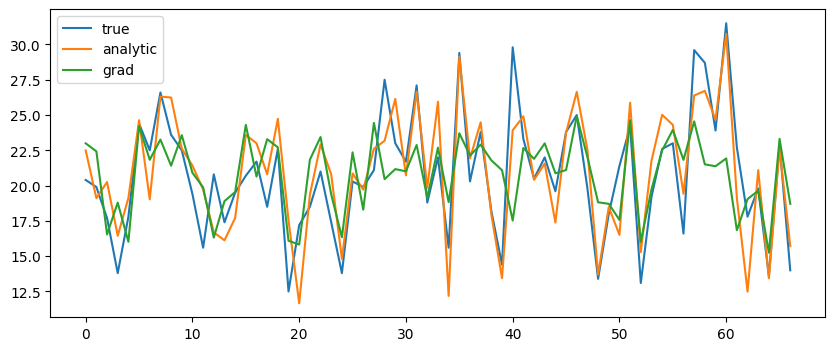

In [4]:
BATCH_SIZE = 8

# Linear regression fit
lin_reg = LinearRegression()

# Analytic fit
lin_reg.fit(X_housing_train, y_housing_train, analytic_fit=True, verbose=False)
y_preds_with_analytic_fit = lin_reg.predict(X_housing_test)
min_ms_error = mse(y_housing_test, lin_reg.predict(X_housing_test))
w_analytic = np.copy(lin_reg.w)

# Mini-batch SGD fit
lin_reg.fit(X_housing_train, y_housing_train, optimizer_class=GradientDescent, batch_size=BATCH_SIZE, verbose=False)
y_preds_with_grad = lin_reg.predict(X_housing_test)
ms_error = mse(y_housing_test, y_preds_with_grad)


print(f"L2 norm between best weights and SGD weights: {np.linalg.norm(w_analytic - lin_reg.w)}")
print(f"Mean squarred error from analytic fit: {min_ms_error}")
print(f"Mean squared error from SGD with mini-batch size {BATCH_SIZE}: {ms_error}")

# plot results
plt.figure(figsize=(10,4))
plt.plot(y_housing_test, label='true')
plt.plot(y_preds_with_analytic_fit, label='analytic')
plt.plot(y_preds_with_grad, label='grad')
plt.legend()
plt.show()

### Logistic Regression

In [5]:
BATCH_SIZE = 64
OPTIMIZER_KWARGS = {'max_iters': 4e4,
                    'learning_rate': 0.05,
                    'verbose': False}

log_reg = LogisticRegression()

# Learn model parameters with gradient descent
log_reg.fit(X_wine_train, y_wine_train, optimizer_class=GradientDescent, **OPTIMIZER_KWARGS)
y_wine_preds_gd = log_reg.predict(X_wine_test)
w_gd = np.copy(log_reg.w)

gd_accuracy = accuracy_score(y_wine_test, y_wine_preds_gd)
gd_recall = recall_score(y_wine_test, y_wine_preds_gd, average='weighted')
gd_precision = precision_score(y_wine_test, y_wine_preds_gd, average='weighted')
gd_f1_score = f1_score(y_wine_test, y_wine_preds_gd, average='weighted')

# Learn model parameters with stochastic gradient descent
log_reg.fit(X_wine_train, y_wine_train, optimizer_class=StochasticGradientDescent, batch_size=BATCH_SIZE, **OPTIMIZER_KWARGS)
y_wine_preds_sgd = log_reg.predict(X_wine_test)
w_sgd = np.copy(log_reg.w)

sgd_accuracy = accuracy_score(y_wine_test, y_wine_preds_sgd)
sgd_recall = recall_score(y_wine_test, y_wine_preds_sgd, average='weighted')
sgd_precision = precision_score(y_wine_test, y_wine_preds_sgd, average='weighted')
sgd_f1_score = f1_score(y_wine_test, y_wine_preds_sgd, average='weighted')

print("l2 norm between sgd weights and mini-batch weights: ", np.linalg.norm(w_gd - w_sgd))
print(f"Accuracy:\n \tGD: {gd_accuracy:.5g}, SGD with mini-batch of size {BATCH_SIZE}: {sgd_accuracy:.5g}")
print(f"Recall:\n \tGD: {gd_recall:.5g}, SGD with mini-batch of size {BATCH_SIZE}: {sgd_recall:.5g}")
print(f"Precision:\n \tGD: {gd_precision:.5g}, SGD with mini-batch of size {BATCH_SIZE}: {sgd_precision:.5g}")
print(f"F1 score:\n \tGD: {gd_f1_score:.5g}, SGD with mini-batch of size {BATCH_SIZE}: {sgd_f1_score:.5g}")

l2 norm between sgd weights and mini-batch weights:  171.58521545348464
Accuracy:
 	GD: 0.87879, SGD with mini-batch of size 64: 0.90909
Recall:
 	GD: 0.87879, SGD with mini-batch of size 64: 0.90909
Precision:
 	GD: 0.90731, SGD with mini-batch of size 64: 0.9096
F1 score:
 	GD: 0.87706, SGD with mini-batch of size 64: 0.90807


### Results
- analytical solution of linear regression performs much better (6 vs 12 MSE)
- Logistic Regression performs really well on the data
- SGD works better than GD with BS 64
- with BS 8, SGD performs worse than GD

# Experiment 2: Cross-Validation

For both data sets, use a 5-fold cross-validation technique and report the performance metrics on both the training set and test set for each model. Again, include appropriate performance metrics for each model. Check this link for more information.

Note: 5-fold cross-validation is a technique where the dataset is divided into five equal parts (folds), and a model is trained and evaluated five times, each time using a different fold as the validation set and the remain- ing four folds for training.


### Data Preparation

In [6]:
IQR_FACTOR = 1.5 

### Data Cleaning ###
#remove outliers (but not for CHAS bc it is 1/0)
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

wine_df_cleaned = wine_df.copy()
wine_df_cleaned = remove_outliers(wine_df_cleaned, factor=IQR_FACTOR)

X_housing = housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy()
y_housing = housing_df_cleaned.MEDV.to_numpy().reshape(-1,1)

X_wine = wine_df_cleaned.drop(['class'], axis=1).to_numpy()
y_wine = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)

### Linear Regression

In [7]:
BATCH_SIZE = 8

errors_analytic_train = []
errors_analytic_test = []
errors_sgd_train = []
errors_sgd_test = []

for X_train_fold, y_train_fold, X_test_fold, y_test_fold in k_fold_split(X_housing, y_housing):
    lin_reg = LinearRegression()

    # data normalization
    X_train_fold, X_test_fold = min_max_scale(X_train_fold, X_test_fold)

    # analytic fit
    lin_reg.fit(X_train_fold, y_train_fold, analytic_fit=True, verbose=False)
    y_preds_with_analytic_fit_train = lin_reg.predict(X_train_fold)
    y_preds_with_analytic_fit_test = lin_reg.predict(X_test_fold)
    errors_analytic_train.append(mse(y_train_fold, y_preds_with_analytic_fit_train))
    errors_analytic_test.append(mse(y_test_fold, y_preds_with_analytic_fit_test))
    w_analytic = np.copy(lin_reg.w)

    # mini-batch SGD fit
    lin_reg.fit(X_train_fold, y_train_fold, optimizer_class=GradientDescent, batch_size=BATCH_SIZE, verbose=False)
    y_preds_with_grad_train = lin_reg.predict(X_train_fold)
    y_preds_with_grad_test = lin_reg.predict(X_test_fold)
    errors_sgd_train.append(mse(y_train_fold, y_preds_with_grad_train))
    errors_sgd_test.append(mse(y_test_fold, y_preds_with_grad_test))

print("Analytic Fit Errors:")
print("Train:", errors_analytic_train)
print("Train Mean:", np.mean(errors_analytic_train))
print("Train Std:", np.std(errors_analytic_train))
print("Test:", errors_analytic_test)
print("Test Mean:", np.mean(errors_analytic_test))
print("Test Std:", np.std(errors_analytic_test))

print("\nMini-Batch SGD Errors:")
print("Train:", errors_sgd_train)
print("Train Mean:", np.mean(errors_sgd_train))
print("Train Std:", np.std(errors_sgd_train))
print("Test:", errors_sgd_test)
print("Test Mean:", np.mean(errors_sgd_test))
print("Test Std:", np.std(errors_sgd_test))

Analytic Fit Errors:
Train: [6.372192267084715, 7.342902925319603, 5.793879094396441, 6.540663300506986, 5.521731089244624]
Train Mean: 6.314273735310474
Train Std: 0.6342900330632179
Test: [7.9708137696004355, 3.77374884543282, 11.745234790995962, 8.652968753532198, 20.008474388885457]
Test Mean: 10.430248109689376
Test Std: 5.421957769396132

Mini-Batch SGD Errors:
Train: [15.272855335080337, 18.55767226444527, 14.251530114474791, 16.53152259673538, 16.771571306163885]
Train Mean: 16.277030323379932
Train Std: 1.4575104299865624
Test: [24.020576412267086, 9.088074811624477, 27.362193570033433, 16.3278879112186, 14.876141233265779]
Test Mean: 18.334974787681876
Test Std: 6.562222660531458


### Logistic Regression

In [8]:
BATCH_SIZE = 64
OPTIMIZER_KWARGS = {'max_iters': 4e4,
                    'learning_rate': 0.05,
                    'verbose': False}

results_gd_train = []
results_gd_test = []
results_sgd_train = []
results_sgd_test = []

for X_train_fold, y_train_fold, X_test_fold, y_test_fold in k_fold_split(X_wine, y_wine):

    log_reg = LogisticRegression()

    # GD fit
    log_reg.fit(X_train_fold, y_train_fold, optimizer_class=GradientDescent, **OPTIMIZER_KWARGS)

    # metrics
    y_train_preds_gd = log_reg.predict(X_train_fold)
    results_gd_train.append(accuracy_score(y_train_fold, y_train_preds_gd))
    y_test_preds_gd = log_reg.predict(X_test_fold)
    results_gd_test.append(accuracy_score(y_test_fold, y_test_preds_gd))

    # SGD fit
    log_reg.fit(X_train_fold, y_train_fold, optimizer_class=StochasticGradientDescent, batch_size=BATCH_SIZE, **OPTIMIZER_KWARGS)

    # metrixs
    y_train_preds_sgd = log_reg.predict(X_train_fold)
    results_sgd_train.append(accuracy_score(y_train_fold, y_train_preds_sgd))
    y_test_preds_sgd = log_reg.predict(X_test_fold)
    results_sgd_test.append(accuracy_score(y_test_fold, y_test_preds_sgd))

# Computing mean and std for each metric
print("Gradient Descent Results:")
print(f"Train Accuracy: Mean {np.mean(results_gd_train).round(5)}, Std {np.std(results_gd_train).round(5)}")
print(f"Test Accuracy: Mean {np.mean(results_gd_test).round(5)}, Std {np.std(results_gd_test).round(5)}")

print("\nSGD Results:")
print(f"Train Accuracy: Mean {np.mean(results_sgd_train).round(5)}, Std {np.std(results_sgd_train).round(5)}")
print(f"Test Accuracy: Mean {np.mean(results_sgd_test).round(5)}, Std {np.std(results_sgd_test).round(5)}")

Gradient Descent Results:
Train Accuracy: Mean 0.92706, Std 0.04314
Test Accuracy: Mean 0.71288, Std 0.32825

SGD Results:
Train Accuracy: Mean 0.83714, Std 0.109
Test Accuracy: Mean 0.72538, Std 0.29766


### Results

- overfitting
- high standard deviation on test set performance

# Experiment 3: Training Set Sizes
For both datasets, Sample growing subsets of the training data (20%,30%,...80%). Observe and explain how does size of training data affects the performance for both models. Plot two curves as a function of training size, one for performance in train and one for test.

### Data Preparation

In [9]:
TEST_SIZE = 0.20
IQR_FACTOR = 1.5 

### Data Cleaning ###
#remove outliers (but not for CHAS bc it is 1/0)
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

wine_df_cleaned = wine_df.copy()
wine_df_cleaned = remove_outliers(wine_df_cleaned, factor=IQR_FACTOR)


### Data Splitting ###
# perform train test split
one_hot_wine_classes = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine_df_cleaned.drop(['class'], axis=1).to_numpy(), 
                                                                        one_hot_wine_classes, test_size=TEST_SIZE)

X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                    housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), test_size=TEST_SIZE)

### Data Normalization ###
# normalize data after train test split to prevent data leakage
#X_wine_train, X_wine_test = min_max_scale(X_wine_train, X_wine_test, scale=True)
X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)

### Linear Regression

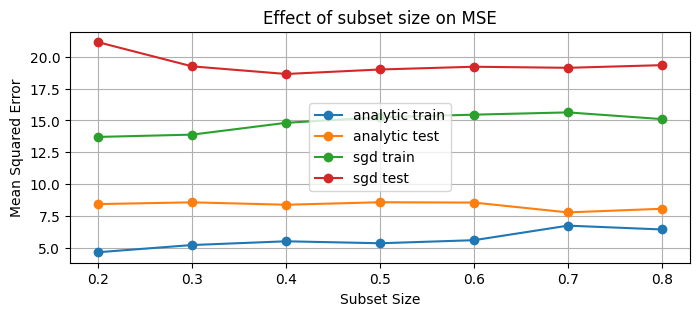

In [10]:
BATCH_SIZE = 16
OPTIMIZER_KWARGS = {'max_iters': 4e4,
                    'learning_rate': 0.05,
                    'verbose': False}

# sizes to sample
sizes = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

analytic_train_errors = []
analytic_test_errors = []
sgd_train_errors = []
sgd_test_errors = []

for size in sizes:
    # Splitting the data
    subset_size = int(size * X_housing_train.shape[0])
    X_train_subset = X_housing_train[:subset_size]
    y_train_subset = y_housing_train[:subset_size]

    lin_reg = LinearRegression()

    # analytic fit
    lin_reg.fit(X_train_subset, y_train_subset, analytic_fit=True, verbose=False)
    y_preds_with_analytic_fit_train = lin_reg.predict(X_train_subset)
    y_preds_with_analytic_fit_test = lin_reg.predict(X_housing_test)
    analytic_train_errors.append(mse(y_train_subset, y_preds_with_analytic_fit_train))
    analytic_test_errors.append(mse(y_housing_test, y_preds_with_analytic_fit_test))

    # mini-batch SGD fit
    lin_reg.fit(X_train_subset, y_train_subset, optimizer_class=GradientDescent, batch_size=BATCH_SIZE, verbose=False)
    y_preds_with_grad_train = lin_reg.predict(X_train_subset)
    y_preds_with_grad_test = lin_reg.predict(X_housing_test)
    sgd_train_errors.append(mse(y_train_subset, y_preds_with_grad_train))
    sgd_test_errors.append(mse(y_housing_test, y_preds_with_grad_test))

plt.figure(figsize=(8,3))
plt.plot(sizes, analytic_train_errors, '-o',label='analytic train')
plt.plot(sizes, analytic_test_errors, '-o',label='analytic test')
plt.plot(sizes, sgd_train_errors, '-o',label='sgd train')
plt.plot(sizes, sgd_test_errors, '-o',label='sgd test')
plt.xlabel('Subset Size')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Effect of subset size on MSE')
plt.grid(True)
plt.show()


### Logistic Regression

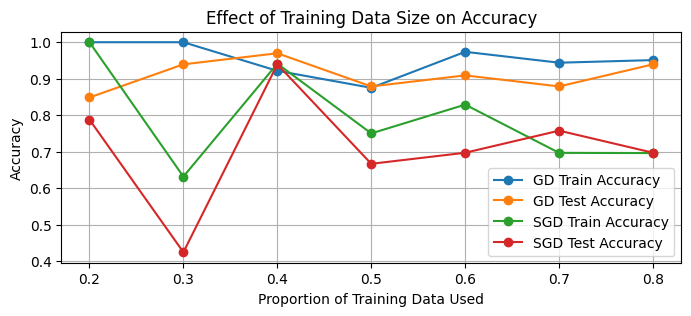

In [11]:
BATCH_SIZE = 8
OPTIMIZER_KWARGS = {'max_iters': 4e4,
                    'learning_rate': 0.05,
                    'verbose': False}

# sizes to sample
sizes = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

gd_train_accuracies = []
gd_test_accuracies = []
sgd_train_accuracies = []
sgd_test_accuracies = []

for size in sizes:
    # Splitting the data
    subset_size = int(size * X_wine_train.shape[0])
    X_train_subset = X_wine_train[:subset_size]
    y_train_subset = y_wine_train[:subset_size]
    
    # Training with Gradient Descent
    log_reg.fit(X_train_subset, y_train_subset, optimizer_class=GradientDescent, **OPTIMIZER_KWARGS)
    gd_train_accuracies.append(accuracy_score(y_train_subset, log_reg.predict(X_train_subset)))
    gd_test_accuracies.append(accuracy_score(y_wine_test, log_reg.predict(X_wine_test)))
    
    # Training with SGD
    log_reg.fit(X_train_subset, y_train_subset, optimizer_class=StochasticGradientDescent, batch_size=BATCH_SIZE, **OPTIMIZER_KWARGS)
    sgd_train_accuracies.append(accuracy_score(y_train_subset, log_reg.predict(X_train_subset)))
    sgd_test_accuracies.append(accuracy_score(y_wine_test, log_reg.predict(X_wine_test)))

# Plotting the results
plt.figure(figsize=(8, 3))
plt.plot(sizes, gd_train_accuracies, '-o', label="GD Train Accuracy")
plt.plot(sizes, gd_test_accuracies, '-o', label="GD Test Accuracy")
plt.plot(sizes, sgd_train_accuracies, '-o', label="SGD Train Accuracy")
plt.plot(sizes, sgd_test_accuracies, '-o', label="SGD Test Accuracy")
plt.xlabel("Proportion of Training Data Used")
plt.ylabel("Accuracy")
plt.title("Effect of Training Data Size on Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Results

**Linear Regression**
- generalization performance increases with more data for analytical solution
- for SGD starting eith 40%, performance is really stable independent of the amount of data

**Logistic Regression**
- performance peak already with only 40% of the data for training 
- logistic regression performance decreases afterwards
- linear regression stays on some sort of plateau, indicating that not more data is needed

# Experiment 4: Minibatch Sizes
For both datasets, try out growing minibatch sizes, e.g., 8, 16, 32, 64, and 128. Compare the convergence speed and final performance of different batch sizes to the fully batched baseline. Which configuration works the best among the ones you tried?
Note: This is for SGD only (Task2, third main task).

### Data Preparation

In [12]:
TEST_SIZE = 0.2
IQR_FACTOR = 1.5

### Data Cleaning ###
#remove outliers (but not for CHAS bc it is 1/0)
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

#wine_df_cleaned = remove_outliers(wine_df, factor=IQR_FACTOR)
wine_df_cleaned = wine_df.copy()
wine_df_cleaned = remove_outliers(wine_df_cleaned, factor=IQR_FACTOR)

### Data Splitting ###
# perform train test split
one_hot_wine_classes = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine_df_cleaned.drop(['class'], axis=1).to_numpy(), 
                                                                        one_hot_wine_classes, test_size=TEST_SIZE)

X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                    housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), test_size=TEST_SIZE)

### Data Normalization ###
# normalize data after train test split to prevent data leakage
#X_wine_train, X_wine_test = min_max_scale(X_wine_train, X_wine_test, scale=True)
X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)

### Linear Regression

In [21]:
OPTIMIZER_KWARGS = {'max_iters': 4e4,
                    'learning_rate': 0.05,
                    'verbose': False}

batch_sizes = [8, 16, 32, 64, 128, X_housing_train.shape[0]]

sgd_train_errors = []
sgd_test_errors = []
convergence_speeds = []

for batch_size in batch_sizes:
    lin_reg = LinearRegression()

    start_time = time.time()
    lin_reg.fit(X_housing_train, y_housing_train, optimizer_class=StochasticGradientDescent, batch_size=batch_size, **OPTIMIZER_KWARGS)
    end_time = time.time()
    
    y_preds_with_grad_train = lin_reg.predict(X_housing_train)
    y_preds_with_grad_test = lin_reg.predict(X_housing_test)
    sgd_train_errors.append(mse(y_housing_train, y_preds_with_grad_train))
    sgd_test_errors.append(mse(y_housing_test, y_preds_with_grad_test))
    convergence_speeds.append(end_time - start_time)

for batch_size, train_error, test_error, speed in zip(batch_sizes, sgd_train_errors, sgd_test_errors, convergence_speeds):
    print(f"Batch Size: {batch_size}, Train Error: {train_error:.3f}, Test Error: {test_error:.3f}, Convergence Speed: {speed:.3f}")

Batch Size: 8, Train Error: 15.441, Test Error: 17.537, Convergence Speed: 2.763
Batch Size: 16, Train Error: 15.441, Test Error: 17.513, Convergence Speed: 2.601
Batch Size: 32, Train Error: 15.466, Test Error: 17.393, Convergence Speed: 2.656
Batch Size: 64, Train Error: 15.430, Test Error: 17.636, Convergence Speed: 3.243
Batch Size: 128, Train Error: 15.440, Test Error: 17.782, Convergence Speed: 3.052
Batch Size: 266, Train Error: 15.434, Test Error: 17.585, Convergence Speed: 3.437


### Logistic Regression

In [13]:
OPTIMIZER_KWARGS = {'max_iters': 4e4,
                    'learning_rate': 0.05,
                    'verbose': False}

batch_sizes = [8, 16, 32, 64, 128, X_wine_train.shape[0]]  # The last entry is for full-batch SGD

# Placeholder lists to store results
sgd_train_accuracies = []
sgd_test_accuracies = []
convergence_speeds = []  # You can track this as number of epochs, training time, etc.

for batch_size in batch_sizes:
    # Reset the model (important to start from same initial weights)
    log_reg = LogisticRegression()
    
    # Track start time (to measure convergence speed)
    start_time = time.time()
    
    # Training with SGD
    log_reg.fit(X_wine_train, y_wine_train, optimizer_class=StochasticGradientDescent, batch_size=batch_size, **OPTIMIZER_KWARGS)
    
    # Track end time
    end_time = time.time()
    
    # Append results
    sgd_train_accuracies.append(accuracy_score(y_wine_train, log_reg.predict(X_wine_train)))
    sgd_test_accuracies.append(accuracy_score(y_wine_test, log_reg.predict(X_wine_test)))
    convergence_speeds.append(end_time - start_time)

# Display the results
for batch_size, train_acc, test_acc, speed in zip(batch_sizes, sgd_train_accuracies, sgd_test_accuracies, convergence_speeds):
    print(f"Batch size {batch_size}: Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Convergence Time: {speed:.2f} seconds")

Batch size 8: Train Acc: 0.9062, Test Acc: 0.9091, Convergence Time: 4.17 seconds
Batch size 16: Train Acc: 0.9375, Test Acc: 0.9091, Convergence Time: 4.04 seconds
Batch size 32: Train Acc: 0.8672, Test Acc: 0.8788, Convergence Time: 4.20 seconds
Batch size 64: Train Acc: 0.8594, Test Acc: 0.6970, Convergence Time: 4.39 seconds
Batch size 128: Train Acc: 0.7344, Test Acc: 0.5455, Convergence Time: 5.08 seconds
Batch size 128: Train Acc: 0.8672, Test Acc: 0.7879, Convergence Time: 4.95 seconds


# Experiment 5: Different Learning Rates
For both datasets, Present the performance of both linear and logistic regression with at least three different learning rates (your own choice).

### Data Preparation

In [22]:
TEST_SIZE = 0.20
IQR_FACTOR = 1.5

### Data Cleaning ###
#remove outliers (but not for CHAS bc it is 1/0)
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

wine_df_cleaned = wine_df.copy()
wine_df_cleaned = remove_outliers(wine_df, factor=IQR_FACTOR)

### Data Splitting ###
# perform train test split
one_hot_wine_classes = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine_df_cleaned.drop(['class'], axis=1).to_numpy(),
                                                                        one_hot_wine_classes,
                                                                        test_size=TEST_SIZE)

X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                    housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), test_size=TEST_SIZE)

### Data Normalization ###
# normalize data after train test split to prevent data leakage
#X_wine_train, X_wine_test = min_max_scale(X_wine_train, X_wine_test)
X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)

### Linear Regression

Learning Rate: 0.005, Train Error: 19.377, Test Error: 15.418
Learning Rate: 0.01, Train Error: 18.507, Test Error: 14.792
Learning Rate: 0.05, Train Error: 16.432, Test Error: 13.298
Learning Rate: 0.1, Train Error: 15.586, Test Error: 12.664
Learning Rate: 0.2, Train Error: 14.353, Test Error: 11.253
Learning Rate: 0.5, Train Error: 12.148, Test Error: 9.901
Learning Rate: 0.7, Train Error: 11.465, Test Error: 9.389
Learning Rate: 1.0, Train Error: 10.887, Test Error: 9.408


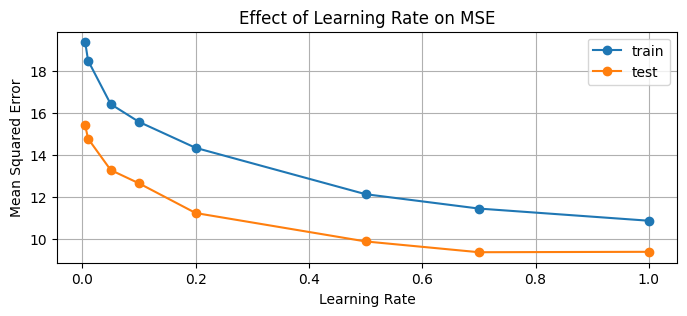

In [27]:
OPTIMIZER_KWARGS = {
    'batch_size': 32, 
    'max_iters': 4e4, 
    'verbose': False
    }
LEARNING_RATES = [0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 1.0]

train_errors = []
test_errors = []

for lr in LEARNING_RATES:
    lin_reg = LinearRegression()

    lin_reg.fit(X_housing_train, y_housing_train, optimizer_class=StochasticGradientDescent, learning_rate=lr, **OPTIMIZER_KWARGS)
    
    y_preds_with_grad_train = lin_reg.predict(X_housing_train)
    y_preds_with_grad_test = lin_reg.predict(X_housing_test)
    train_errors.append(mse(y_housing_train, y_preds_with_grad_train))
    test_errors.append(mse(y_housing_test, y_preds_with_grad_test))

    print(f"Learning Rate: {lr}, Train Error: {train_errors[-1]:.3f}, Test Error: {test_errors[-1]:.3f}")

# plot results of different learning rates
plt.figure(figsize=(8,3))
plt.plot(LEARNING_RATES, train_errors, '-o',label='train')
plt.plot(LEARNING_RATES, test_errors, '-o',label='test')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Effect of Learning Rate on MSE')
plt.grid(True)
plt.show()


### Logistic Regression

Learning Rate: 0.005, Train Accuracy: 0.953, Test Accuracy: 0.939
Learning Rate: 0.01, Train Accuracy: 0.891, Test Accuracy: 0.788
Learning Rate: 0.05, Train Accuracy: 0.930, Test Accuracy: 0.879
Learning Rate: 0.1, Train Accuracy: 0.953, Test Accuracy: 0.939
Learning Rate: 0.2, Train Accuracy: 0.953, Test Accuracy: 0.939
Learning Rate: 0.5, Train Accuracy: 0.898, Test Accuracy: 0.818
Learning Rate: 0.7, Train Accuracy: 0.945, Test Accuracy: 0.939
Learning Rate: 1.0, Train Accuracy: 0.945, Test Accuracy: 0.939


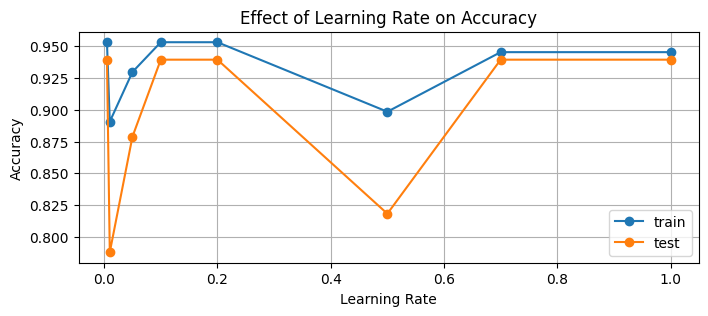

In [32]:
OPTIMIZER_KWARGS = {
    'batch_size': 64, 
    'max_iters': 4e4, 
    'verbose': False
    }
LEARNING_RATES = [0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 1.0]

train_accuracies = []
test_accuracies = []

for lr in LEARNING_RATES:
    log_reg = LogisticRegression()

    log_reg.fit(X_wine_train, y_wine_train, optimizer_class=StochasticGradientDescent, learning_rate=lr, **OPTIMIZER_KWARGS)
    
    y_preds_with_grad_train = log_reg.predict(X_wine_train)
    y_preds_with_grad_test = log_reg.predict(X_wine_test)
    train_accuracies.append(accuracy_score(y_wine_train, y_preds_with_grad_train))
    test_accuracies.append(accuracy_score(y_wine_test, y_preds_with_grad_test))

    print(f"Learning Rate: {lr}, Train Accuracy: {train_accuracies[-1]:.3f}, Test Accuracy: {test_accuracies[-1]:.3f}")

# plot results of different learning rates
plt.figure(figsize=(8,3))
plt.plot(LEARNING_RATES, train_accuracies, '-o',label='train')
plt.plot(LEARNING_RATES, test_accuracies, '-o',label='test')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Effect of Learning Rate on Accuracy')
plt.grid(True)
plt.show()

### Results

**Linear Regression**
- the higher the learning rate, the lower the error

**Logistic Regression**
- much more unstable, no clear trend

# Experiment 6: Different Parameter Configurations
For both datasets, Given a variety of parameter configurations, select a performance metric and present the optimal parameter choice for each dataset. Please provide a rationale for your metric selection, along with an explanation of why you opted for that particular metric

### Linear Regression

In [50]:
PARAM_GRID = {
    'IQR_FACTOR': [1.0, 1.5, 2.0],
    'BATCH_SIZE': [1, 8, 32, 64, 128],
    'LEARNING_RATE': [0.01, 0.1, 0.5],
    'MAX_ITERS': [1e4, 1e5],
    'MOMENTUM': [0.0, 0.5, 0.9]
}
TEST_SIZE = 0.20

print(f"Number of combinations: {len(list(product(*PARAM_GRID.values())))}")

count = 1
results = []

for params in product(*PARAM_GRID.values()):
    IQR_FACTOR = params[0]
    OPTIMIZER_KWARGS = {
        'batch_size': params[1],
        'learning_rate': params[2],
        'max_iters': params[3],
        'beta': params[4],
        'verbose': False
    }

    ### Data Cleaning ###
    temp_df = housing_df.drop(columns='CHAS')
    temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
    housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

    ### Data Splitting ###
    # split into train, validation, and test sets
    X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                        housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), test_size=TEST_SIZE)

    X_housing_train, X_housing_val, y_housing_train, y_housing_val = train_test_split(X_housing_train, y_housing_train, test_size=TEST_SIZE)                                                                                    

    ### Data Normalization ###
    X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)

    lin_reg = LinearRegression()

    start_time = time.time()
    lin_reg.fit(X_housing_train, y_housing_train, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
    end_time = time.time()

    y_preds_with_grad_train = lin_reg.predict(X_housing_train)
    y_preds_with_grad_test = lin_reg.predict(X_housing_test)
    mse_train = mse(y_housing_train, y_preds_with_grad_train)
    mse_val = mse(y_housing_val, lin_reg.predict(X_housing_val))
    mse_test = mse(y_housing_test, y_preds_with_grad_test)

    # save results
    param_dict = dict(zip(PARAM_GRID.keys(), params))
    result_dict = {
        'IQR_FACTOR': param_dict['IQR_FACTOR'],
        'BATCH_SIZE': param_dict['BATCH_SIZE'],
        'LEARNING_RATE': param_dict['LEARNING_RATE'],
        'MAX_ITERS': param_dict['MAX_ITERS'],
        'MOMENTUM': param_dict['MOMENTUM'],
        'Train MSE': mes_train,
        'Test MSE': mse_test,
        'Convergence Speed': end_time - start_time
    }
    results.append(result_dict)

    print(f"No {count}: Params: {params}, Train Error: {mse_train:.3f}, Test Error: {mse_test:.3f}")
    count += 1

Number of combinations: 270
Params: (1.0, 1, 0.01, 10000.0, 0.0), Train Error: 14.718, Test Error: 12.392
Params: (1.0, 1, 0.01, 10000.0, 0.5), Train Error: 13.042, Test Error: 17.330
Params: (1.0, 1, 0.01, 10000.0, 0.9), Train Error: 12.775, Test Error: 18.463
Params: (1.0, 1, 0.01, 100000.0, 0.0), Train Error: 13.175, Test Error: 8.733
Params: (1.0, 1, 0.01, 100000.0, 0.5), Train Error: 12.243, Test Error: 13.661
Params: (1.0, 1, 0.01, 100000.0, 0.9), Train Error: 12.832, Test Error: 10.989
Params: (1.0, 1, 0.1, 10000.0, 0.0), Train Error: 13.762, Test Error: 13.156
Params: (1.0, 1, 0.1, 10000.0, 0.5), Train Error: 12.768, Test Error: 15.357
Params: (1.0, 1, 0.1, 10000.0, 0.9), Train Error: 12.736, Test Error: 16.216
Params: (1.0, 1, 0.1, 100000.0, 0.0), Train Error: 9.646, Test Error: 14.484
Params: (1.0, 1, 0.1, 100000.0, 0.5), Train Error: 11.092, Test Error: 9.242
Params: (1.0, 1, 0.1, 100000.0, 0.9), Train Error: 10.666, Test Error: 11.882
Params: (1.0, 1, 0.5, 10000.0, 0.0), Tr

In [ ]:
# TODO plot results for different parameters
results_df = pd.DataFrame(results)

### Logistic Regression

In [33]:
PARAM_GRID = {
    'IQR_FACTOR': [1.0, 1.5, 2.0],
    'BATCH_SIZE': [1, 8, 32, 64, 128],
    'LEARNING_RATE': [0.01, 0.1, 0.5],
    'MAX_ITERS': [1e4, 1e5],
    'MOMENTUM': [0.0, 0.5, 0.9]
}
TEST_SIZE = 0.20
print(f"Number of combinations: {len(list(product(*PARAM_GRID.values())))}")

best_params = None
best_accuracy = 0

param_search_results = []

for params in product(*PARAM_GRID.values()):
    IQR_FACTOR = params[0]
    OPTIMIZER_KWARGS = {
        'batch_size': params[1],
        'learning_rate': params[2],
        'max_iters': params[3],
        'beta': params[4],
        'verbose': False
    }

    ### Data Cleaning ###
    wine_df_cleaned = wine_df.copy()
    wine_df_cleaned = remove_outliers(wine_df_cleaned, factor=IQR_FACTOR)

    ### Data Splitting ###
    one_hot_wine_classes = pd.get_dummies(wine_df_cleaned['class']).to_numpy(dtype=int)
    X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(wine_df_cleaned.drop(['class'], axis=1).to_numpy(), 
                                                                        one_hot_wine_classes, test_size=TEST_SIZE)

    log_reg = LogisticRegression()

    start_time = time.time()
    log_reg.fit(X_wine_train, y_wine_train, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
    end_time = time.time()

    y_preds_with_grad_train = log_reg.predict(X_wine_train)
    y_preds_with_grad_test = log_reg.predict(X_wine_test)
    accuracy_train = accuracy_score(y_wine_train, y_preds_with_grad_train)
    accuracy_test = accuracy_score(y_wine_test, y_preds_with_grad_test)

    param_search_results.append((params, accuracy_train, accuracy_test))

    if accuracy_test > best_accuracy:
        best_accuracy = accuracy_test
        best_params = params

    print(f"Params: {params}, Train Accuracy: {accuracy_train:.3f}, Test Accuracy: {accuracy_test:.3f}")

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Params: {best_params}")
    


### Results

**Linear Regression**
- Best Params: 
    - IQR factor: 1.0
    - Batch Size: 32
    - Learning Rate: 0.5
    - Max Epochs: 100000
    - Momentum: 0.5
    - Test MSE: 5.778

**Logistic Regression**
- x

# Experiment 7: Gaussian Basis Functions

Only for dataset1, Gaussian Basis Functions:
- Utilize Gaussian basis functions to enrich the feature set for Dataset 1. • Define each Gaussian basis function as follows:
  
$$\phi_j(x) = exp(-\frac{||x-\mu_j||^2}{2s^2})$$

- Employ a total of 5 Gaussian basis functions.
- Set the spatial scale parameter, s, to a value of 1.
- Select μj values randomly from the training set to determine the centers of these basis functions.
- Use analytical linear regression to predict the target value.
- Compare the target and predicted values obtained with the new dataset with the results obtained with the original feature set, i.e. compare with the results obtained without Gaussian basis functions.

### Data Preparation

In [71]:
IQR_FACTOR = 1.5
TEST_SIZE = 0.2

### Data Cleaning ###
temp_df = housing_df.drop(columns='CHAS')
temp_df_cleaned = remove_outliers(temp_df, factor=IQR_FACTOR)
housing_df_cleaned = pd.concat([temp_df_cleaned, housing_df['CHAS'].loc[temp_df_cleaned.index]], axis=1)

### Data Splitting ###
X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(housing_df_cleaned.drop(['MEDV'], axis=1).to_numpy(),
                                                                                    housing_df_cleaned.MEDV.to_numpy().reshape(-1,1), test_size=TEST_SIZE)

### Data Normalization ###
X_housing_train, X_housing_test = min_max_scale(X_housing_train, X_housing_test)


In [72]:
import numpy as np

num_basis_functions = 5
s = 1.0
feature_index = 0

def calculate_gaussian_basis_functions(x, mu_values, s):
    return [np.exp(-np.linalg.norm(x - mu)**2 / (2 * s**2)) for mu in mu_values]

def compute_basis_features(X, feature_index, mu_values, s):
    num_samples = X.shape[0]
    basis_features = np.empty((num_samples, num_basis_functions))
    for i in range(num_samples):
        basis_features[i, :] = calculate_gaussian_basis_functions(X[i, feature_index], mu_values, s)
    return basis_features

# Get mu_values for the selected feature
random_indices = np.random.choice(len(X_housing_train), num_basis_functions)
mu_values = X_housing_train[random_indices, feature_index]

# Compute and add Gaussian basis functions to training data
basis_functions_train = compute_basis_features(X_housing_train, feature_index, mu_values, s)
X_housing_train_gaussian = np.hstack((X_housing_train, basis_functions_train))
print("Shape of basis_functions_train:", basis_functions_train.shape)

# Compute and add Gaussian basis functions to test data
basis_functions_test = compute_basis_features(X_housing_test, feature_index, mu_values, s)
X_housing_test_gaussian = np.hstack((X_housing_test, basis_functions_test))
print("Shape of basis_functions_test:", basis_functions_test.shape)


Shape of basis_functions_train: (266, 5)
Shape of basis_functions_test: (67, 5)


### Linear Regression

Without Gaussian Basis Functions:
Analytic Fit MSE: 6.157
SGD Fit MSE: 15.031

With Gaussian Basis Functions:
Analytic Fit MSE: 33.027
SGD Fit MSE: 14.976


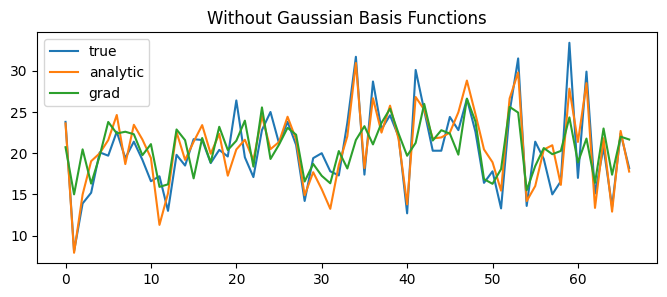

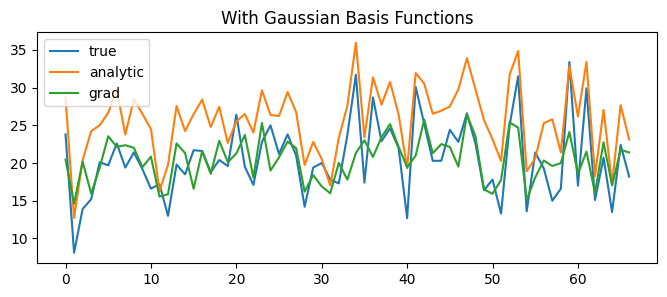

In [75]:
OPTIMIZER_KWARGS = {'batch_size': 32,
                    'max_iters': 4e4,
                    'learning_rate': 0.05,
                    'verbose': False}


lin_reg = LinearRegression()

### Without Gaussian Basis Functions ###
# Analytic fit
lin_reg.fit(X_housing_train, y_housing_train, analytic_fit=True, verbose=False)
y_preds_with_analytic_fit = lin_reg.predict(X_housing_test)
min_ms_error = mse(y_housing_test, lin_reg.predict(X_housing_test))
w_analytic = np.copy(lin_reg.w)

# Mini-batch SGD fit
lin_reg.fit(X_housing_train, y_housing_train, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
y_preds_with_grad = lin_reg.predict(X_housing_test)
ms_error = mse(y_housing_test, y_preds_with_grad)

### With Gaussian Basis Functions ###
# Analytic fit
lin_reg.fit(X_housing_train_gaussian, y_housing_train, analytic_fit=True, verbose=False)
y_preds_with_analytic_fit_gaussian = lin_reg.predict(X_housing_test_gaussian)
min_ms_error_gaussian = mse(y_housing_test, lin_reg.predict(X_housing_test_gaussian))
w_analytic_gaussian = np.copy(lin_reg.w)

# Mini-batch SGD fit
lin_reg.fit(X_housing_train_gaussian, y_housing_train, optimizer_class=StochasticGradientDescent, **OPTIMIZER_KWARGS)
y_preds_with_grad_gaussian = lin_reg.predict(X_housing_test_gaussian)
ms_error_gaussian = mse(y_housing_test, y_preds_with_grad_gaussian)


# print 
print("Without Gaussian Basis Functions:")
print(f"Analytic Fit MSE: {min_ms_error:.3f}")
print(f"SGD Fit MSE: {ms_error:.3f}")
print("\nWith Gaussian Basis Functions:")
print(f"Analytic Fit MSE: {min_ms_error_gaussian:.3f}")
print(f"SGD Fit MSE: {ms_error_gaussian:.3f}")

# plot
# plot results
plt.figure(figsize=(8,3))
plt.plot(y_housing_test, label='true')
plt.plot(y_preds_with_analytic_fit, label='analytic')
plt.plot(y_preds_with_grad, label='grad')
plt.title('Without Gaussian Basis Functions')
plt.legend()
plt.show()

plt.figure(figsize=(8,3))
plt.plot(y_housing_test, label='true')
plt.plot(y_preds_with_analytic_fit_gaussian, label='analytic')
plt.plot(y_preds_with_grad_gaussian, label='grad')
plt.title('With Gaussian Basis Functions')
plt.legend()
plt.show()

### Results

- adding Gaussian Basis Functions improved the SGD fit very slightly 
- significantly decreased the analytic fit
- in this specific context, may not be helpful when using an analytic method

# Experiment 8: Analytical vs. Mini-Batch Stochastic Gradient Descent
Only for dataset1, Compare analytical linear regression solution with mini-batch stochastic gradient descent- based linear regression solution. What do you find? Why do you think mini-batch stochastic gradient descent is used when an analytical solution is available?

### Results

- we can use results from experiments before
- SGD is much faster than analytical solution
- more flexibility in terms of SGD, tuning hyperparameters to the specific problem
- SGD can be used for much larger datasets